# Presentation

### Importing Libraries, data, and models

In [39]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import _pickle as pickle
import numpy as np
import pandas as pd
from joblib import load
from sklearn.preprocessing import StandardScaler

# Preventing error from occuring: XGBoost causes kernel to die.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost as xgb


from fbprophet import Prophet as proph
import warnings
warnings.filterwarnings('ignore')

# Reregistering Matplotlib due to FBProphet
pd.plotting.register_matplotlib_converters()

#### Loading the Classification Model

In [2]:
# Loading Pretrained XGBoost Model
clf = load("Classification/classifier_model.joblib")

#### Loading the Data

In [41]:
# Loading the top 10 features DF for scaling purposes
with open("Classification/top10_df.pkl", "rb") as fp:
    df = pickle.load(fp)
    
# Loading the new data for classification purposes
with open("Classification/stockpup.pkl", "rb") as fp:
    og_df = pickle.load(fp)
    
# Loading the ticker dictionary
with open("Classification/tickers.pkl", "rb") as fp:
    tickers = pickle.load(fp)

### Functions

In [103]:
def format_stock(df):
    """
    Formats the selected stock DF for use later on
    """
    
    # Setting the Datetime index
    df['Quarter end'] = pd.to_datetime(df['Quarter end'])
    df = df.set_index("Quarter end")
    
    # Replacing all "None" values with 0
    df = df.replace("None", 0)
    
    # Sorting the DF
    df = df.sort_index(ascending=True)
    
    # Converting to numeric values
    df = df.apply(pd.to_numeric)
    
    # Changing values to percent change
    for c in df.columns:
        df[c] = df[c].pct_change(1)*100
        
    # Replacing inf values with 1 and-1, as well as handling remaining NaNs
    df = df.replace([np.inf, -np.inf], [1,-1]).fillna(0)
    
    return df

In [104]:
def classify_me(df1, df2, selected):
    """
    Returns the latest quarterly report available with the appropriate columns and scales it to the trained data
    """
    # Formatting the selected stock
    select_df = format_stock(df1[selected]).sort_index(ascending=True).tail(1)

    # Narrowing down the stock to the most recent QR with the neccessary columns
    select_df = select_df[[i for i in df2.columns if i != 'Decision']]

    # Resetting the the index to be able to append to the top 10 DF
    select_df = select_df.reset_index(drop=True)

    # Dropping the decision column from the top 10 DF
    dropped = df2.drop("Decision", 1)

    # Appending the new data to the top 10 DF for scaling purposes
    dropped = dropped.append(select_df)

    # Instantiating the scaler
    scaler = StandardScaler()

    # Scaling the features
    features_df = dropped

    scaled_df = pd.DataFrame(scaler.fit_transform(features_df), 
                                   index=features_df.index, 
                                   columns=features_df.columns)

    return scaled_df.iloc[[-1]]

In [184]:
def pie_stock(pred, name):
    """
    Creates a pie chart of the stock class predictions
    """
    rcParams['font.size'] = 30.0
    plt.style.use('bmh')
    plt.figure(figsize=(10,10))
    plt.pie(pred[0], 
            labels=['SELL', 'BUY','HOLD'], 
            shadow=True,
            explode=(0,.07,0),
            autopct='%1.1f%%')
    plt.title(name)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [185]:
def fbp(ts, pers=90):
    """
    Plots the forecast of the FBProphet model
    """
    plt.style.use('fivethirtyeight')
    rcParams['figure.figsize'] = 24,16

    # Instantiating the FBP
    mod = proph(interval_width=.95, daily_seasonality=True)
    
    # Fitting the model
    mod.fit(ts)
    
    # Making future Dataframes
    future = mod.make_future_dataframe(periods=pers, freq='D')
    
    # Forecasting
    forecast = mod.predict(future)
        
    # Plotting the forecast
    mod.plot(forecast, uncertainty=True)
    
    plt.title(f"Forecasted Prices\nfor the next {pers} periods")
    plt.xlabel("Dates")
    plt.ylabel("Price")
    plt.xlim(['2017', '2020'])
    plt.show()

In [186]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import random
import glob
import os
import time

def closing_prices(stock):
    """
    Using Selenium to scrape the prices from Yahoo Finance
    """
    try:
        # Randomize wait times
        seq = [i/10 for i in range(3,12)]

        # Options to help load the page faster
        chromeOptions = Options()
        prefs = {"profile.managed_default_content_settings.images":2,
                 "profile.default_content_setting_values.notifications":2,
                 "profile.managed_default_content_settings.stylesheets":2,
                 "profile.managed_default_content_settings.cookies":1,
                 "profile.managed_default_content_settings.javascript":1,
                 "profile.managed_default_content_settings.plugins":2,
                 "profile.managed_default_content_settings.popups":2,
                 "profile.managed_default_content_settings.geolocation":2,
                 "profile.managed_default_content_settings.media_stream":2}
        chromeOptions.add_experimental_option("prefs",prefs)
        chromeOptions.add_extension(r"/Users/flatironschool/Desktop/extension_1_22_4_0.crx")

        # Opening a browser to google search
        driver = webdriver.Chrome(options=chromeOptions)
        driver.set_window_size(720,640)
        driver.implicitly_wait(2)
        driver.get("https://google.com")

        # Searching for the stock by ticker's corresponding company name
        search = driver.find_element(By.XPATH, "//input[@class='gLFyf gsfi']")
        search.send_keys(f"{tickers[stock.upper()]} yahoo finance")
        search.send_keys(Keys.RETURN)
        time.sleep(random.choice(seq))

        # Clicking the top google result
        try:
            search_res = driver.find_element(By.XPATH, "//*[@id='rso']/div/div/div[1]/div/div/div[1]/a/h3")
            search_res.click()
        except:
            search_res = driver.find_element(By.XPATH, "//*[@id='rso']/div[1]/div/div/div/div[1]/a/h3")
            search_res.click()
        

        # Clicking the historical data
        hist_but = driver.find_element(By.XPATH, "//*[@id='quote-nav']/ul/li[6]/a")
        hist_but.click()
        time.sleep(random.choice(seq))
        
        # Clicking the date range
        date_rg = driver.find_element(By.XPATH, "//input[@class='C(t) O(n):f Tsh($actionBlueTextShadow) Bd(n) Bgc(t) Fz(14px) Pos(r) T(-1px) Bd(n):f Bxsh(n):f Cur(p) W(190px)']")
        date_rg.click()
        time.sleep(random.choice(seq))

        # Clicking "Max", then "Done", then "Apply"
        max_but = driver.find_element(By.XPATH, "//*[@id='Col1-1-HistoricalDataTable-Proxy']/section/div[1]/div[1]/div[1]/span[2]/div/div[1]/span[8]")
        max_but.click()
        time.sleep(random.choice(seq))

        done = driver.find_element(By.XPATH, "//*[@id='Col1-1-HistoricalDataTable-Proxy']/section/div[1]/div[1]/div[1]/span[2]/div/div[3]/button[1]")
        done.click()
        time.sleep(random.choice(seq))

        apply = driver.find_element(By.XPATH, "//*[@id='Col1-1-HistoricalDataTable-Proxy']/section/div[1]/div[1]/button/span")
        apply.click()
        time.sleep(random.choice(seq))

        # Finally downloading the CSV
        download = driver.find_element(By.XPATH, "//*[@id='Col1-1-HistoricalDataTable-Proxy']/section/div[1]/div[2]/span[2]/a/span")

        download.click()
        time.sleep(random.choice(seq))

        # Closing the window
        driver.quit()
    
    except:
        print("Could not find stock data...\nQuitting browser")
        driver.quit()

In [187]:
def grab_csv():
    """
    Loading in the csv file with closing prices downloaded from Yahoo finance
    """
    # File list retrieved from local download folder
    list_of_files = glob.glob('../../Downloads/*.csv') 
    
    # Assigning the most recent file
    latest_file = max(list_of_files, key=os.path.getctime)
    return pd.read_csv(latest_file)

In [188]:
def forecast_me(stock):    
    # Selenium script to download the latest closing prices
    closing_prices(stock)

    # Grabbing the most recently downloaded csv
    df = grab_csv()

    # Selecting the necessary columns for FBP
    ts = df[['Date', 'Close']].tail(1000)

    # Renaming the columns for use in FB prophet
    ts.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

    # Running the FBprophet model
    return fbp(ts)

## Analyzing the Stock

Which stock would you like to analyze? dis


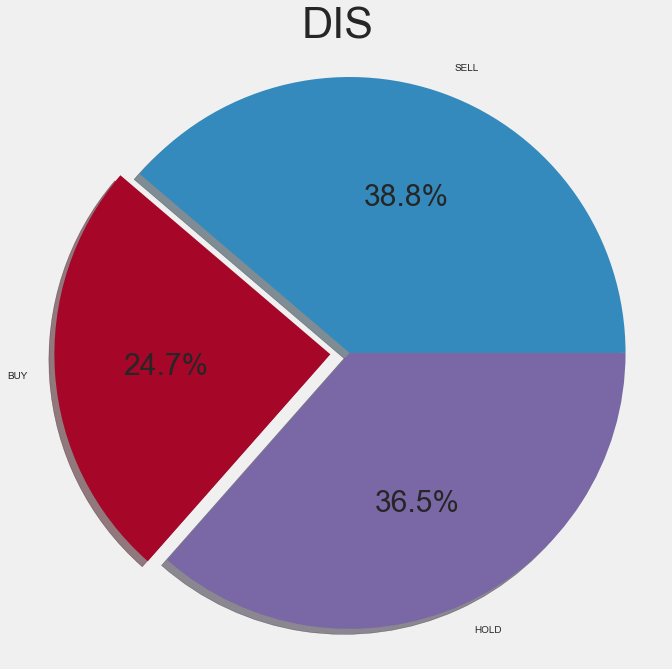

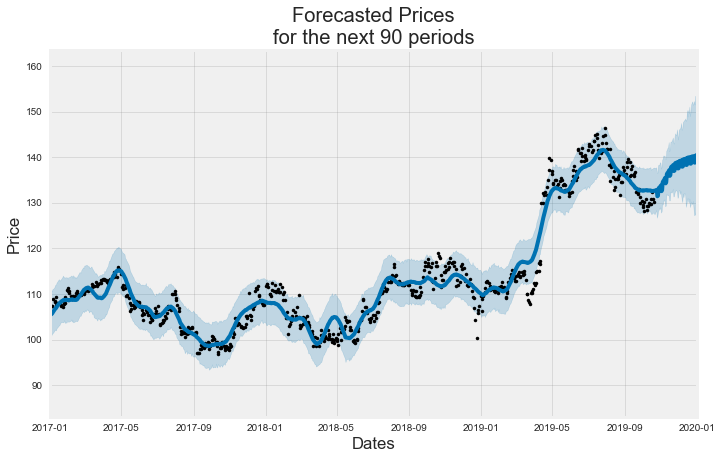

In [190]:
while True:
    try:
        # Asking for user input on stock ticker
        selected = input("Which stock would you like to analyze? ").upper()

        # Breaking from user input
        if selected == 'BREAK':
            break
        
        # Assigning the DF of the newest scaled QR
        X = classify_me(og_df, df, selected)

        # Getting the predicted probabilities of XGBoost classifier
        prediction = clf.predict_proba(X)

        # Making a pie chart out of the predictions
        pie_stock(prediction, selected)
        
        # Forecasting the selected stock using FBProphet
        forecast_me(selected)
        break
        
    except:
        print("\nCould not find selected stock.\nPlease try again...\n")